In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import os
import DataLoad
import ImagePreprocessor
import Labeling
import TrajectoryPhy
import umap

report_path = 'result/report_all.csv'

2023-01-22 16:40:38.031664: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
header, data = DataLoad.read_report(report_path)
print(header)
print(data[0])

['filename', 'id', 'class_id', 'class_name', 'probability', 'maximum_radius', 'first_x_position', 'first_y_position']
{'filename': '20220301_H2B Halo_Field3_no_ir001', 'id': '2', 'class_id': '0', 'class_name': 'Immobile', 'probability': '0.9990927', 'maximum_radius': '0.08163692542593697', 'first_x_position': '12.683669', 'first_y_position': '12.079526'}


In [36]:
max_rs_immobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='0']))
max_rs_hybrid = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='1']))
max_rs_mobile = np.array(list([float(x['maximum_radius']) for x in data if x['class_id']=='2']))

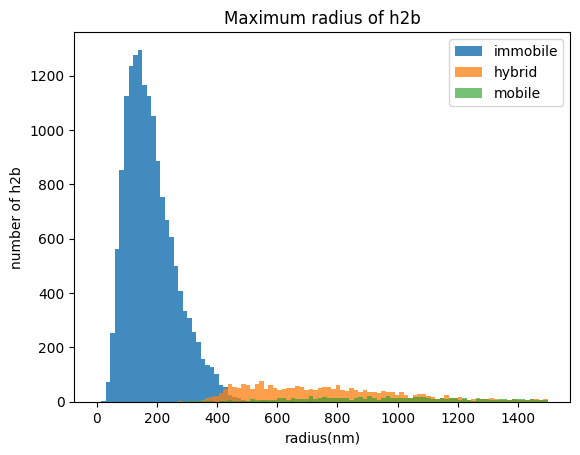

In [44]:
plt.figure()
plt.title('Maximum radius of h2b')
plt.hist(max_rs_immobile*1000, range = (0, 1500), bins = 100, alpha=0.85, label='immobile')
plt.hist(max_rs_hybrid*1000, range = (0, 1500), bins = 100, alpha=0.75, label='hybrid')
plt.hist(max_rs_mobile*1000, range = (0, 1500), bins = 100, alpha=0.65, label='mobile')
plt.xlabel('radius(nm)')
plt.ylabel('number of h2b')
plt.legend()
plt.show()

In [ ]:
data_path = './data/TrainingSample'
print(f'Loading the data...')
histones = DataLoad.read_files(path=data_path, cutoff=10, chunk=False)
histones_label = Labeling.make_label(histones, radius=0.45, density=0.4)

print(f'Image processing...')
ImagePreprocessor.make_channel(histones, immobile_cutoff=0.3, hybrid_cutoff=10, nChannel=3)
histones_imgs, img_size, time_scale = \
    ImagePreprocessor.preprocessing(histones, img_scale=10, amp=2)

print(f'Making imgs...')
zoomed_imgs, scaled_size = ImagePreprocessor.zoom(histones_imgs, size=img_size, to_size=(500, 500))

reshaped_label = []
reshaped_imgs = []
for histone in zoomed_imgs:
    reshaped_imgs.append(zoomed_imgs[histone].reshape(-1))
    reshaped_label.append(histones_label[histone])
reshaped_imgs = np.array(reshaped_imgs)
print(reshaped_imgs.shape)

reducer = umap.UMAP(n_neighbors=5)
embedding = reducer.fit_transform(reshaped_imgs)
print(f'Data reducing end')

Loading the data...
Image processing...
Making imgs...
(2400, 750000)


In [ ]:
print(embedding.shape)  
color_vec = []
for i in range(len(reshaped_label)):
    if reshaped_label[i] == 0:
        color_vec.append('red')
    elif reshaped_label[i] == 1:
        color_vec.append('green')
    else:
        color_vec.append('blue')
        
fig, ax = plt.subplots()
for p in range(reshaped_imgs.shape[0]):
    ax.scatter(
        embedding[p][0],
        embedding[p][1],
        color=color_vec[p],
        alpha=0.5,
        s=9
    )
plt.title(f'UMAP projection between classes', fontsize=12)
plt.savefig(f'img/training_imgs/1.png')